# Въведение в Машинното Обучение

Това ръководство представя основните концепции в машинното обучение с прости примери на български език.

## 1. Обучение с Учител (Supervised Learning)

### Какво е обучение с учител?

**Обучението с учител** е като обучението на дете с помощта на учител, който знае правилните отговори. Показваме на модела много примери, като за всеки пример знаем какъв трябва да бъде отговорът.

**Аналогия**: Представете си, че учите дете да разпознава животни. Показвате му снимки и казвате "това е куче", "това е котка". След време детето може само да разпознава животните.

### Ключовата концепция: Етикетирани данни

В обучението с учител всеки пример има:
- **Входни данни (features)**: Характеристиките, които описват примера
- **Етикет (label)**: Правилният отговор, който искаме да научим модела да предсказва

**Пример**:
- Входни данни: Тегло = 150г, Диаметър = 7см
- Етикет: "Ябълка"

Моделът учи връзката между входните данни и етикетите.

### Два основни типа задачи

#### 1. Класификация
Предсказваме **категория** или **клас**
- Спам или не спам?
- Котка или куче?
- Ябълка или лимон?

#### 2. Регресия
Предсказваме **число**
- Каква ще бъде цената на къща?
- Колко ще бъде температурата утре?
- Колко продажби ще има?

**Днес ще решим задача за класификация!**

### Практически пример: Класификация на плодове

Ще научим модел да разпознава дали плод е **ябълка** или **лимон** въз основа на две характеристики:
1. **Тегло** (в грама)
2. **Диаметър** (в сантиметри)

Нека започнем стъпка по стъпка!

#### Стъпка 1: Импортиране на необходимите библиотеки

Ще използваме:
- `numpy`: За работа с масиви от данни
- `sklearn`: За машинно обучение (Decision Tree модел)
- `matplotlib`: За визуализация (ще използваме по-късно)

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

print("Библиотеките са заредени успешно!")

Библиотеките са заредени успешно!


#### Стъпка 2: Създаване на тренировъчни данни

Ще създадем данни за 6 плода - 3 ябълки и 3 лимона. За всеки плод записваме тегло и диаметър.

**Важно**: В реалния свят тези данни биха дошли от измервания или база данни.

In [2]:
# Входни данни (features): [тегло в грама, диаметър в см]
X = np.array([
    [150, 7],   # ябълка 1
    [170, 7.5], # ябълка 2
    [140, 7],   # ябълка 3
    [130, 3],   # лимон 1
    [150, 3.5], # лимон 2
    [140, 3.2]  # лимон 3
])

# Етикети (labels): 0 = ябълка, 1 = лимон
y = np.array([0, 0, 0, 1, 1, 1])

print("Данни създадени!")
print(f"Форма на X: {X.shape} (6 примера, 2 характеристики)")
print(f"Форма на y: {y.shape} (6 етикета)")

Данни създадени!
Форма на X: (6, 2) (6 примера, 2 характеристики)
Форма на y: (6,) (6 етикета)


#### Стъпка 3: Визуализация на данните

Преди да обучим модел, нека да видим как изглеждат данните. Това ни помага да разберем дали плодовете могат да бъдат разделени.

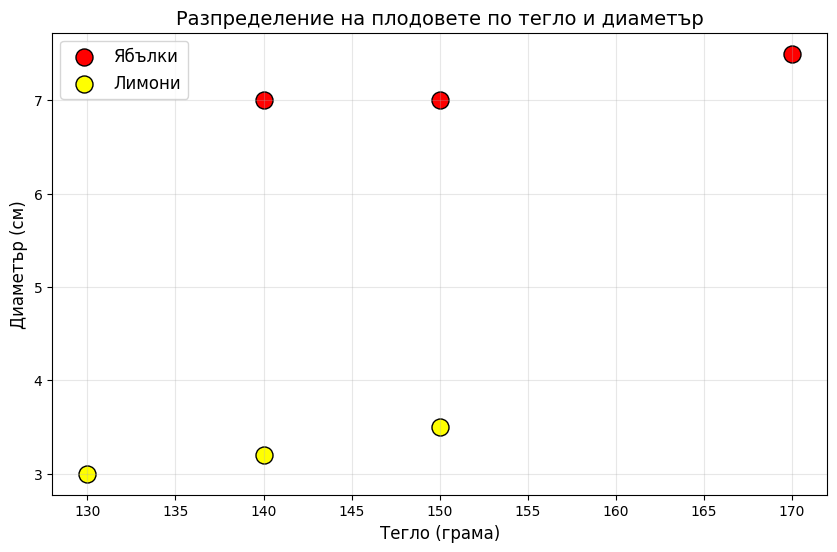

Забележете: Ябълките са по-големи и тежки, лимоните са по-малки!


In [3]:
plt.figure(figsize=(10, 6))

# Разделяме данните по вид плод
apples = X[y == 0]   # ябълки
lemons = X[y == 1]   # лимони

# Рисуваме двата вида с различни цветове
plt.scatter(apples[:, 0], apples[:, 1], c='red', s=150, label='Ябълки', marker='o', edgecolors='black')
plt.scatter(lemons[:, 0], lemons[:, 1], c='yellow', s=150, label='Лимони', marker='o', edgecolors='black')

plt.xlabel('Тегло (грама)', fontsize=12)
plt.ylabel('Диаметър (см)', fontsize=12)
plt.title('Разпределение на плодовете по тегло и диаметър', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("Забележете: Ябълките са по-големи и тежки, лимоните са по-малки!")

#### Стъпка 4: Създаване и обучение на модел

**Decision Tree (Дърво на решенията)** е популярен алгоритъм за класификация. Работи като поредица от въпроси:
- "Теглото над 145г ли е?"
  - Ако ДА → "Диаметърът над 5см ли е?"
    - Ако ДА → Вероятно е ябълка
    - Ако НЕ → Вероятно е лимон

Нека обучим модела на нашите данни!

In [4]:
# Създаване на модел
model = DecisionTreeClassifier(random_state=42)

# Обучение на модела
model.fit(X, y)

print("✓ Моделът е обучен успешно!")
print(f"Моделът запомни {len(X)} примера")

✓ Моделът е обучен успешно!
Моделът запомни 6 примера


#### Стъпка 5: Предсказване на нови данни

Сега когато моделът е обучен, можем да му дадем **нов плод**, който не е виждал, и той ще предскаже какъв е.

In [5]:
# Нов плод, който моделът не е виждал
new_fruit = np.array([[145, 7.2]])

# Предсказание
prediction = model.predict(new_fruit)
fruit_name = "ябълка" if prediction[0] == 0 else "лимон"

print(f"🍎 Входни данни: Тегло = {new_fruit[0][0]}г, Диаметър = {new_fruit[0][1]}см")
print(f"🔮 Предсказание: {fruit_name}")
print(f"\nМоделът предсказва, че плодът е {fruit_name}!")

🍎 Входни данни: Тегло = 145.0г, Диаметър = 7.2см
🔮 Предсказание: ябълка

Моделът предсказва, че плодът е ябълка!


#### Какво научихме за обучението с учител?

✅ **Етикетирани данни**: Всеки пример има правилен отговор
✅ **Обучение**: Моделът учи от примери
✅ **Предсказване**: Моделът може да класифицира нови, невиждани данни
✅ **Decision Tree**: Прави предсказания чрез поредица от въпроси

**Ключов момент**: Колкото повече качествени данни имаме, толкова по-добре модел учи!

---

## 2. Обучение без Учител (Unsupervised Learning)

### Какво е обучение без учител?

**Обучението без учител** е метод, при който даваме на модела данни **без етикети** и той сам трябва да открие структури, модели и зависимости.

**Аналогия**: Представете си, че давате на дете куп играчки и то само започва да ги групира по цвят, размер или форма, без вие да му казвате как да го направи.

### Основната разлика от обучението с учител

| Характеристика | С учител | Без учител |
|---------------|----------|------------|
| **Етикети** | ✓ Имаме | ✗ Нямаме |
| **Цел** | Предсказване | Откриване на структури |
| **Примери** | Класификация, Регресия | Клъстериране, Намаляване на размерност |
| **Употреба** | Спам филтър, Цени | Сегментация на клиенти, Анализ на данни |

### Клъстериране (Clustering)

**Клъстерирането** е най-популярната техника за обучение без учител. Целта е да групираме сходни обекти заедно.

**Как работи K-Means клъстериране?**
1. Избираме колко групи (клъстера) искаме - например 3
2. Алгоритъмът намира центровете на тези групи
3. Всеки обект се отнася към най-близкия център
4. Центровете се преизчисляват, докато групите стабилизират

**Реални приложения:**
- Сегментация на клиенти за маркетинг
- Групиране на новини по теми
- Анализ на медицински данни

### Практически пример: Сегментация на клиенти

Една компания има данни за клиентите си, но **не знае** как да ги категоризира. Ще използваме клъстериране, за да открием естествени групи въз основа на:
1. **Годишен доход** (в хил. лв.)
2. **Брой покупки** годишно

Нека видим какви групи ще открие алгоритъмът!

#### Стъпка 1: Импортиране на библиотеката за клъстериране

In [6]:
from sklearn.cluster import KMeans

print("✓ KMeans е зареден и готов за клъстериране!")

✓ KMeans е зареден и готов за клъстериране!


#### Стъпка 2: Създаване на данните за клиенти

Имаме 8 клиента с различни доходи и брой покупки. **Забележете**: Нямаме етикети за това на коя група принадлежат!

In [7]:
# Данни за клиенти: [годишен доход в хил. лв., брой покупки]
X_customers = np.array([
    [15, 2],   # клиент 1
    [16, 3],   # клиент 2
    [18, 2],   # клиент 3
    [70, 25],  # клиент 4
    [65, 28],  # клиент 5
    [80, 30],  # клиент 6
    [40, 10],  # клиент 7
    [45, 12]   # клиент 8
])

print(f"Създадени данни за {len(X_customers)} клиента")
print(f"Форма на данните: {X_customers.shape}")
print("\nПървите 3 клиента:")
print(X_customers[:3])

Създадени данни за 8 клиента
Форма на данните: (8, 2)

Първите 3 клиента:
[[15  2]
 [16  3]
 [18  2]]


#### Стъпка 3: Визуализация на суровите данни

Преди да приложим клъстериране, нека да видим как изглеждат данните. Можем ли очите да забележим групи?

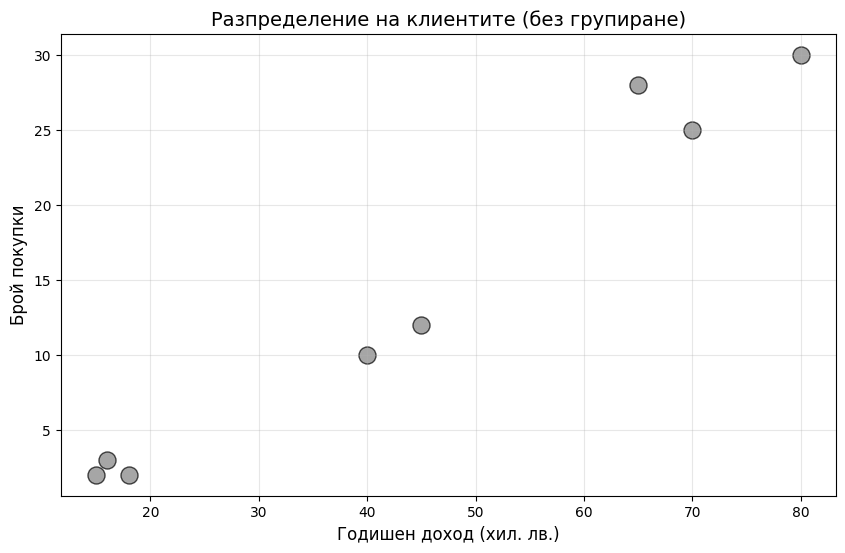

Виждате ли някакви естествени групи в данните?


In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(X_customers[:, 0], X_customers[:, 1], s=150, c='gray', edgecolors='black', alpha=0.7)

plt.xlabel('Годишен доход (хил. лв.)', fontsize=12)
plt.ylabel('Брой покупки', fontsize=12)
plt.title('Разпределение на клиентите (без групиране)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print("Виждате ли някакви естествени групи в данните?")

#### Стъпка 4: Прилагане на K-Means клъстериране

Ще помолим алгоритъма да открие **3 групи** (клъстера) в данните. Той сам ще реши къде са границите между групите.

In [9]:
# Създаване на K-Means модел с 3 клъстера
kmeans = KMeans(n_clusters=3, random_state=42)

# Прилагане на клъстериране
clusters = kmeans.fit_predict(X_customers)

print("✓ Клъстерирането е завършено!")
print(f"\nГрупите на клиентите: {clusters}")
print(f"\nКлиент 1 е в група: {clusters[0]}")
print(f"Клиент 4 е в група: {clusters[3]}")
print(f"Клиент 7 е в група: {clusters[6]}")

✓ Клъстерирането е завършено!

Групите на клиентите: [0 0 0 2 2 1 0 2]

Клиент 1 е в група: 0
Клиент 4 е в група: 2
Клиент 7 е в група: 0


#### Стъпка 5: Визуализация на резултатите

Сега нека да видим как алгоритъмът е групирал клиентите. Всяка група ще има различен цвят, а червените X-ове показват центровете на групите.

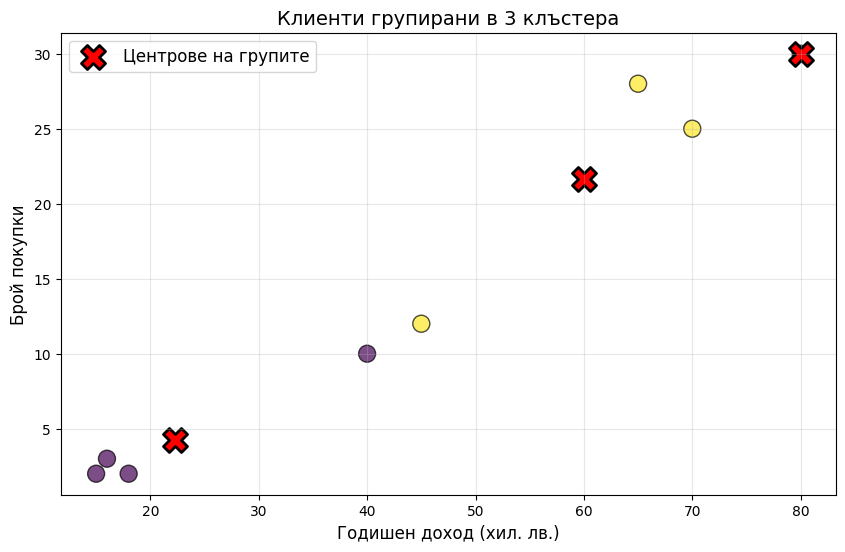

In [10]:
plt.figure(figsize=(10, 6))

# Рисуваме точките, оцветени по групи
plt.scatter(X_customers[:, 0], X_customers[:, 1], c=clusters, cmap='viridis', s=150, edgecolors='black', alpha=0.7)

# Рисуваме центровете на групите
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=300, label='Центрове на групите', edgecolors='black', linewidth=2)

plt.xlabel('Годишен доход (хил. лв.)', fontsize=12)
plt.ylabel('Брой покупки', fontsize=12)
plt.title('Клиенти групирани в 3 клъстера', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### Интерпретация на резултатите

Алгоритъмът откри 3 естествени групи клиенти:

🟣 **Група 1**: Клиенти с нисък доход и малко покупки
🟢 **Група 2**: Клиенти със среден доход и средно покупки  
🟡 **Група 3**: Клиенти с висок доход и много покупки

**Бизнес приложение**: Компанията може да създаде различни маркетингови кампании за всяка група!

✅ **Ключов момент**: Моделът откри тези групи **сам**, без да му казваме предварително какви са те!

---

## 3. Обучение чрез Подкрепление (Reinforcement Learning)

### Какво е обучение чрез подкрепление?

**Обучението чрез подкрепление** е като обучение чрез **опит и грешка**. Агентът прави действия, получава обратна връзка (награда или наказание) и учи какви действия водят до добри резултати.

**Аналогия**: Представете си, че учите куче на трикове. Когато кучето направи правилното действие, получава лакомство (награда). Когато греши, не получава нищо. С времето кучето учи кои действия водят до награди.

### Четирите ключови компонента

#### 1. 🤖 Агент (Agent)
Системата, която взема решения и учи. Пример: робот, игрален AI, самоуправляващ се автомобил.

#### 2. 🌍 Среда (Environment)
Светът, в който действа агентът. Всичко извън агента с което той взаимодейства.

#### 3. ⚡ Действие (Action)
Решението, което агентът взема на всяка стъпка. Пример: "движи се наляво", "скочи", "купи акция".

#### 4. 🎁 Награда (Reward)
Обратната връзка след всяко действие. Може да бъде положителна (добре!) или отрицателна (лошо!).

### Цикълът на обучение

```
1. Агентът наблюдава състоянието на средата
2. Агентът избира действие
3. Средата дава награда
4. Агентът се премества в ново състояние
5. Агентът учи от опита
6. Повторение...
```

С времето агентът учи **кои действия** водят до **най-много награди**!

### Практически пример: Навигационен робот

Ще създадем прост робот, който се учи да стига до цел. Представете си робот в коридор с 5 позиции:

```
[START] → [1] → [2] → [3] → [GOAL]
   0        1      2      3      4
```

- Роботът започва на позиция 0
- Целта е на позиция 4
- На всяка стъпка роботът може да се движи надясно
- Ще използваме **Q-Learning** - популярен RL алгоритъм

#### Какво е Q-Learning?

**Q-Learning** е алгоритъм, при който агентът запомня "качеството" (Q-value) на всяко действие във всяко състояние.

**Q-таблица**: Списък, който показва колко ценна е всяка позиция:
- Високо Q-value → "Тази позиция води до целта!"
- Ниско Q-value → "Тази позиция е далеч от целта"

Агентът започва като "празна страница" и постепенно научава стойностите.

#### Стъпка 1: Дефиниране на наградите

Първо трябва да кажем на агента какво е добро и какво е лошо.

In [11]:
def get_reward(position):
    """
    Функция за награда:
    - Ако роботът стигне до целта (позиция 4): +100 точки! 🎉
    - За всяка друга стъпка: -1 точка (наказание за загуба на време)
    """
    if position == 4:  # Целта!
        return 100
    else:
        return -1  # Наказание за всяка стъпка

# Тестваме функцията
print("Награда за позиция 4 (цел):", get_reward(4))
print("Награда за позиция 2:", get_reward(2))

Награда за позиция 4 (цел): 100
Награда за позиция 2: -1


#### Стъпка 2: Създаване на агента

Сега ще създадем агент с Q-таблица, която ще съхранява научените стойности за всяка позиция.

In [12]:
class SimpleAgent:
    def __init__(self):
        # Q-таблица: съхранява стойности за всяка от 5-те позиции
        self.q_table = [0.0, 0.0, 0.0, 0.0, 0.0]
        
        # Хипер-параметри за обучение
        self.learning_rate = 0.1    # Колко бързо учи
        self.discount = 0.9          # Колко цени бъдещите награди
    
    def train_episode(self):
        """Един епизод на обучение - от старт до цел"""
        position = 0  # Започваме от началото
        
        while position < 4:  # Докато не стигнем целта
            # Действие: движим се надясно
            next_position = position + 1
            
            # Получаваме награда
            reward = get_reward(next_position)
            
            # Обновяваме Q-стойността (Q-Learning формула)
            old_value = self.q_table[position]
            next_max = self.q_table[next_position] if next_position < 5 else 0
            new_value = old_value + self.learning_rate * (reward + self.discount * next_max - old_value)
            self.q_table[position] = new_value
            
            # Преминаваме към следващата позиция
            position = next_position

# Създаваме агент
agent = SimpleAgent()
print("✓ Агентът е създаден!")
print(f"Начална Q-таблица: {agent.q_table}")

✓ Агентът е създаден!
Начална Q-таблица: [0.0, 0.0, 0.0, 0.0, 0.0]


#### Стъпка 3: Обучение на агента

Сега ще обучим агента като го карамедновно и отново да стига от старт до цел. Всеки път той ще подобрява Q-таблицата си.

In [13]:
# Обучаваме агента с 50 епизода
print("Започваме обучение...")
for episode in range(50):
    agent.train_episode()
    
    # Показваме напредъка на всеки 10 епизода
    if (episode + 1) % 10 == 0:
        print(f"Епизод {episode + 1}/50 завършен")

print("\n✓ Обучението завърши!")

Започваме обучение...
Епизод 10/50 завършен
Епизод 20/50 завършен
Епизод 30/50 завършен
Епизод 40/50 завършен
Епизод 50/50 завършен

✓ Обучението завърши!


#### Стъпка 4: Разглеждане на резултатите

Нека да видим какво е научил агентът! Q-таблицата сега трябва да показва, че позициите близо до целта са по-ценни.

In [14]:
# Показваме научената Q-таблица
print("📊 Научена Q-таблица:")
print("=" * 40)
for pos, q_value in enumerate(agent.q_table):
    print(f"Позиция {pos}: {q_value:.1f}")

print("\n🎯 Забележете как стойностите нарастват!")
print("Позициите близо до целта имат по-висока стойност.")

📊 Научена Q-таблица:
Позиция 0: 52.1
Позиция 1: 70.1
Позиция 2: 86.0
Позиция 3: 99.5
Позиция 4: 0.0

🎯 Забележете как стойностите нарастват!
Позициите близо до целта имат по-висока стойност.


#### Какво научихме за обучението чрез подкрепление?

✅ **Агент**: Системата, която взема решения и учи
✅ **Среда**: Светът, в който агентът действа
✅ **Награди**: Обратна връзка, която насочва обучението
✅ **Q-Learning**: Агентът учи стойността на всяко състояние/действие
✅ **Опит**: Агентът учи като пробва многократно

**Ключов момент**: Агентът учи **сам** чрез опит - няма нужда да му казваме какви действия да прави на всяка стъпка!

---

## 4. Разделяне на Данни (Train/Test Split)

За да оценим качеството на модел, разделяме данните на:
- **Тренировъчен набор**: За обучение на модела (обикновено 70-80%)
- **Тестов набор**: За оценка на модела (обикновено 20-30%)

### Защо е важно?
Предотвратява **препълване (overfitting)** - когато моделът "запомня" данните, но не генерализира добре.

Тренировъчен набор: 7 примера
Тестов набор: 3 примера

Точност на тренировъчните данни: 99.66%
Точност на тестовите данни: 99.82%


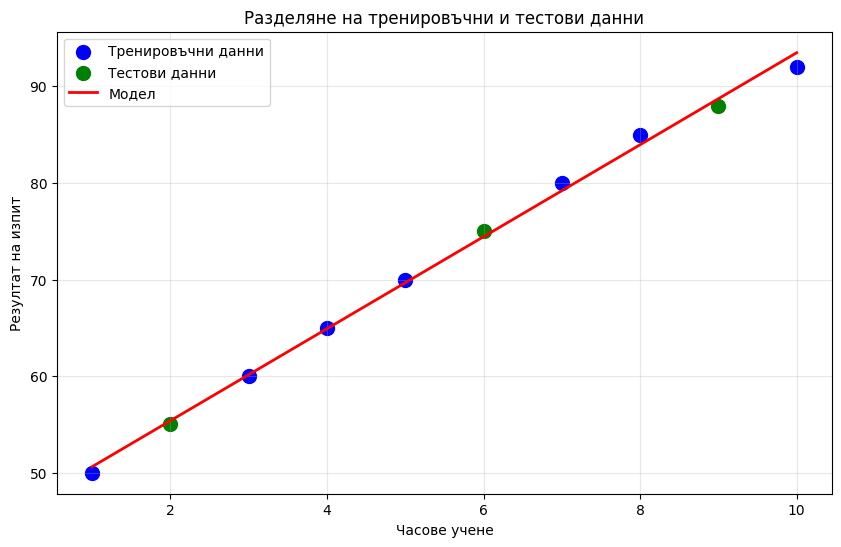

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Данни: часове учене vs резултат на изпит
hours_studied = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)
exam_scores = np.array([50, 55, 60, 65, 70, 75, 80, 85, 88, 92])

# Разделяне на данни: 70% тренировъчни, 30% тестови
X_train, X_test, y_train, y_test = train_test_split(
    hours_studied, exam_scores, test_size=0.3, random_state=42
)

print(f"Тренировъчен набор: {len(X_train)} примера")
print(f"Тестов набор: {len(X_test)} примера")

# Обучение само на тренировъчните данни
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка на тестовите данни
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"\nТочност на тренировъчните данни: {train_score:.2%}")
print(f"Точност на тестовите данни: {test_score:.2%}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Тренировъчни данни', s=100)
plt.scatter(X_test, y_test, color='green', label='Тестови данни', s=100)
plt.plot(hours_studied, model.predict(hours_studied), color='red', label='Модел', linewidth=2)
plt.xlabel('Часове учене')
plt.ylabel('Резултат на изпит')
plt.title('Разделяне на тренировъчни и тестови данни')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Основни Метрики

Метриките ни помагат да оценим качеството на модела.

### За Класификация:
- **Точност (Accuracy)**: Процент правилни предсказания
- **Прецизност (Precision)**: От всички предсказани позитивни, колко са наистина позитивни
- **Пълнота (Recall)**: От всички позитивни, колко сме открили
- **F1-Score**: Хармонична средна на прецизност и пълнота

### За Регресия:
- **MSE (Mean Squared Error)**: Средна квадратична грешка
- **RMSE (Root Mean Squared Error)**: Корен от MSE
- **MAE (Mean Absolute Error)**: Средна абсолютна грешка
- **R² Score**: Коефициент на детерминация (0-1, по-високо е по-добре)

### Пример: Метрики за Класификация

=== МЕТРИКИ ЗА КЛАСИФИКАЦИЯ ===
Точност (Accuracy):     90.00%
Прецизност (Precision): 100.00%
Пълнота (Recall):       80.00%
F1-Score:               88.89%


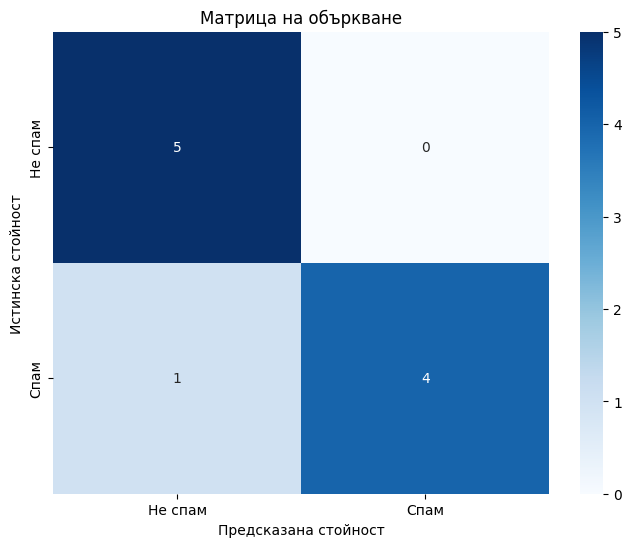


Матрица на объркване:
Верни отрицателни: 5
Фалшиви положителни: 0
Фалшиви отрицателни: 1
Верни положителни: 4


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Примерни данни: предсказване на спам имейли
# 0 = не е спам, 1 = спам
y_true = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0])
y_pred = np.array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

# Изчисляване на метрики
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("=== МЕТРИКИ ЗА КЛАСИФИКАЦИЯ ===")
print(f"Точност (Accuracy):     {accuracy:.2%}")
print(f"Прецизност (Precision): {precision:.2%}")
print(f"Пълнота (Recall):       {recall:.2%}")
print(f"F1-Score:               {f1:.2%}")

# Матрица на объркване (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не спам', 'Спам'],
            yticklabels=['Не спам', 'Спам'])
plt.ylabel('Истинска стойност')
plt.xlabel('Предсказана стойност')
plt.title('Матрица на объркване')
plt.show()

print(f"\nМатрица на объркване:")
print(f"Верни отрицателни: {cm[0, 0]}")
print(f"Фалшиви положителни: {cm[0, 1]}")
print(f"Фалшиви отрицателни: {cm[1, 0]}")
print(f"Верни положителни: {cm[1, 1]}")

### Пример: Метрики за Регресия

=== МЕТРИКИ ЗА РЕГРЕСИЯ ===
MSE (Средна квадратична грешка):  43.75
RMSE (Корен от MSE):              6.61 хил. лв.
MAE (Средна абсолютна грешка):    6.25 хил. лв.
R² Score:                         97.86%


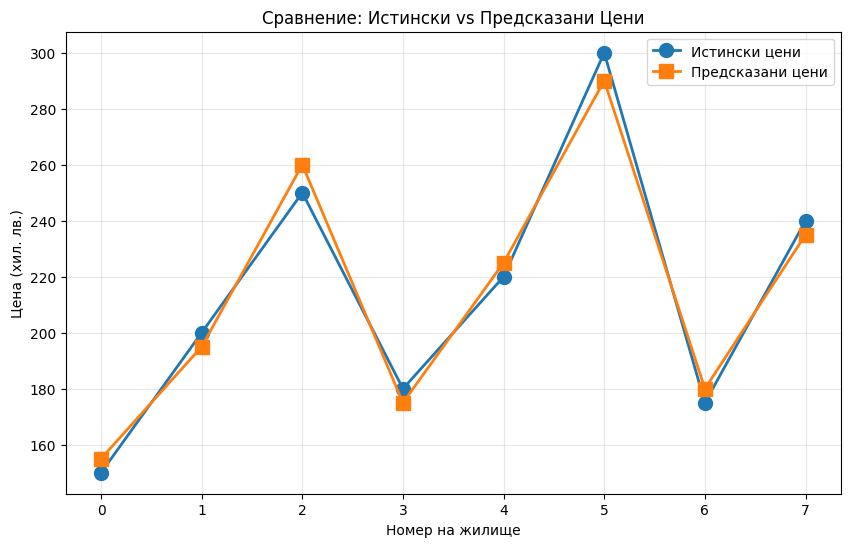


По-ниските стойности на MSE, RMSE и MAE означават по-добър модел.
R² от 0.99 (99%) означава, че моделът обяснява 99% от вариацията в данните!


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Примерни данни: предсказване на цени на жилища
y_true_prices = np.array([150, 200, 250, 180, 220, 300, 175, 240])
y_pred_prices = np.array([155, 195, 260, 175, 225, 290, 180, 235])

# Изчисляване на метрики
mse = mean_squared_error(y_true_prices, y_pred_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_prices, y_pred_prices)
r2 = r2_score(y_true_prices, y_pred_prices)

print("=== МЕТРИКИ ЗА РЕГРЕСИЯ ===")
print(f"MSE (Средна квадратична грешка):  {mse:.2f}")
print(f"RMSE (Корен от MSE):              {rmse:.2f} хил. лв.")
print(f"MAE (Средна абсолютна грешка):    {mae:.2f} хил. лв.")
print(f"R² Score:                         {r2:.2%}")

# Визуализация
plt.figure(figsize=(10, 6))
x_axis = range(len(y_true_prices))
plt.plot(x_axis, y_true_prices, 'o-', label='Истински цени', linewidth=2, markersize=10)
plt.plot(x_axis, y_pred_prices, 's-', label='Предсказани цени', linewidth=2, markersize=10)
plt.xlabel('Номер на жилище')
plt.ylabel('Цена (хил. лв.)')
plt.title('Сравнение: Истински vs Предсказани Цени')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nПо-ниските стойности на MSE, RMSE и MAE означават по-добър модел.")
print("R² от 0.99 (99%) означава, че моделът обяснява 99% от вариацията в данните!")

## Обобщение

### 📚 Научихме:

1. **Обучение с учител**: Модел с известни отговори (класификация и регресия)
2. **Обучение без учител**: Модел открива структури без етикети (клъстериране)
3. **Обучение чрез подкрепление**: Модел се учи чрез награди и наказания
4. **Train/Test Split**: Разделяне на данни за обучение и тестване
5. **Метрики**: Измерване на качеството на модела

### 🎯 Следващи стъпки:
- Експериментирайте с различни модели
- Опитайте се с реални данни
- Научете за кръстосана валидация (cross-validation)
- Изучавайте дълбоко обучение (deep learning)